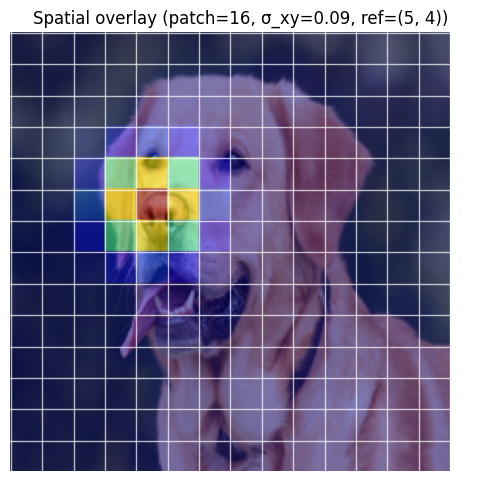

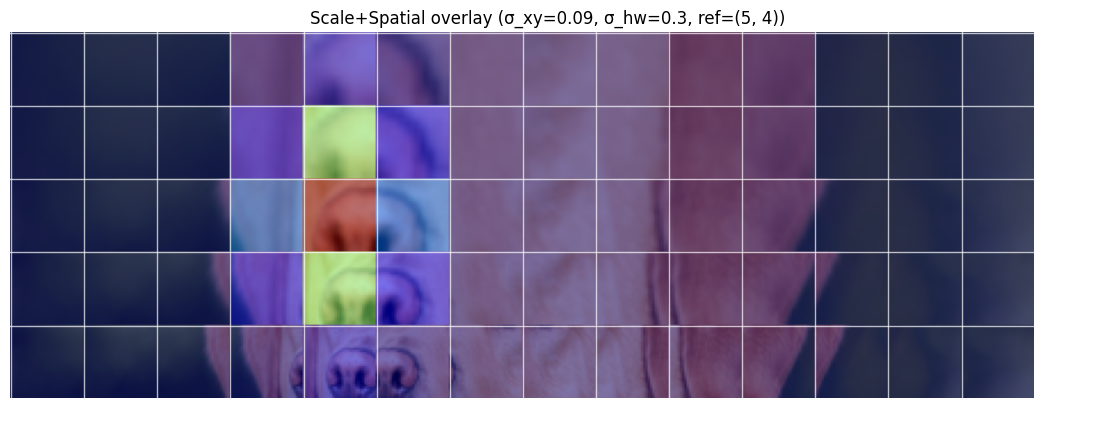

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def overlay_spatial_kernel_on_real_image(
    img_path: str,
    sigma_xy: float,
    patch_size: int = 16,
    ref_patch: tuple[int, int] = None
):
    """
    Overlay a spatial Gaussian kernel heatmap on a real image, 
    with grid lines marking patch boundaries. Allows specifying the reference patch.
    
    img_path:       Path to the image file.
    sigma_xy:      Sigma for spatial kernel.
    patch_size:    Size of each patch (in pixels).
    ref_patch:     (row_idx, col_idx) in patch-grid coords. If None, defaults to center patch.
    """
    # Load and resize image to 224×224
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    img_arr = np.array(img) / 255.0
    H, W = img_arr.shape[:2]
    grid_rows = H // patch_size
    grid_cols = W // patch_size

    # Determine reference patch
    if ref_patch is None:
        pr, pc = grid_rows // 2, grid_cols // 2
    else:
        pr, pc = ref_patch

    # Compute weight for each patch based on distance to reference patch
    coords = np.indices((grid_rows, grid_cols)).transpose(1, 2, 0)
    deltas = np.linalg.norm(coords - np.array([pr, pc]), axis=-1)
    # normalize deltas to [0,1]
    deltas_norm = deltas / deltas.max()
    weights = np.exp(- (deltas_norm**2) / (2 * sigma_xy**2))
    # Upsample weights to full image resolution
    heatmap = np.kron(weights, np.ones((patch_size, patch_size)))

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_arr, origin='upper')
    ax.imshow(heatmap, origin='upper', cmap='jet', alpha=0.5)
    ax.set_title(f"Spatial overlay (patch={patch_size}, σ_xy={sigma_xy}, ref={ref_patch or 'center'})")
    ax.axis('off')

    # Draw grid lines for patch boundaries
    for x in range(0, W+1, patch_size):
        ax.axvline(x, color='white', linewidth=1, alpha=0.7)
    for y in range(0, H+1, patch_size):
        ax.axhline(y, color='white', linewidth=1, alpha=0.7)
    
    plt.show()


def overlay_scale_spatial_kernel_on_real_image(
    img_path: str,
    sigma_xy: float,
    sigma_hw: float,
    patch_size: int = 16,
    k: int = 3,
    ref_patch: tuple[int, int] = None
):
    """
    Create a grid of crops at varying scales (rows) and x-positions (columns),
    based on a reference patch index, each resized to fill its cell,
    and overlay a combined spatial+scale Gaussian kernel heatmap.

    ref_patch: (row_idx, col_idx) in patch-grid coordinates.
    """
    # Load and resize image
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    img_arr = np.array(img) / 255.0
    H, W = img_arr.shape[:2]
    grid_rows = H // patch_size
    grid_cols = W // patch_size

    # Determine reference patch
    if ref_patch is None:
        pr, pc = grid_rows // 2, grid_cols // 2
    else:
        pr, pc = ref_patch

    # Compute scales & weights
    scales = np.logspace(np.log10(1/k), np.log10(k), 2*k + 1)
    log_scales = np.log(scales)

    # Spatial weights along x (columns) relative to reference col
    cols = np.arange(grid_cols)
    dx_norm = (cols - pc) / (grid_cols - 1) * 2  # normalize to [-1,1]
    spatial_w = np.exp(-dx_norm[None,:]**2 / (2 * sigma_xy**2))

    # Scale weights per row
    scale_w = np.exp(-log_scales[:,None]**2 / (2 * sigma_hw**2))

    # Combined weights
    combined_w = scale_w * spatial_w  # shape (rows, cols)

    # Prepare canvas
    max_size = int(patch_size * k)
    rows = combined_w.shape[0]
    cols = grid_cols
    canvas = np.ones((rows*max_size, cols*max_size, 3), dtype=float)

    # Fill canvas with resized crops
    for i, scale in enumerate(scales):
        size = max(1, int(patch_size * scale))
        half = size // 2
        for j in range(cols):
            # Compute center pixel of patch (row pr, col j)
            y_center = pr * patch_size + patch_size//2
            x_center = j * patch_size + patch_size//2
            y0 = max(0, y_center-half)
            y1 = min(H, y_center+half)
            x0 = max(0, x_center-half)
            x1 = min(W, x_center+half)
            region = img_arr[y0:y1, x0:x1]
            # Resize region to fill cell
            region_img = Image.fromarray((region*255).astype(np.uint8))
            resized = np.array(
                region_img.resize((max_size, max_size), resample=Image.BILINEAR)
            ) / 255.0
            canvas[i*max_size:(i+1)*max_size, j*max_size:(j+1)*max_size] = resized

    # Plot overlay
    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.imshow(canvas, origin='upper')
    ax.imshow(
        np.kron(combined_w, np.ones((max_size, max_size))),
        origin='upper',
        cmap='jet',
        alpha=0.5
    )
    ax.set_title(f"Scale+Spatial overlay (σ_xy={sigma_xy}, σ_hw={sigma_hw}, ref={ref_patch or 'center'})")
    ax.axis('off')

    # Draw grid lines
    for j in range(cols+1):
        ax.axvline(j*max_size, color='white', lw=1, alpha=0.7)
    for i in range(rows+1):
        ax.axhline(i*max_size, color='white', lw=1, alpha=0.7)

    plt.show()


# Example usage:
overlay_spatial_kernel_on_real_image('../../artifacts/labrador.jpg', sigma_xy=0.09, ref_patch=(5,4))
overlay_scale_spatial_kernel_on_real_image(
    '../../artifacts/labrador.jpg', sigma_xy=0.09, sigma_hw=0.3, k=2, ref_patch=(5,4)
)



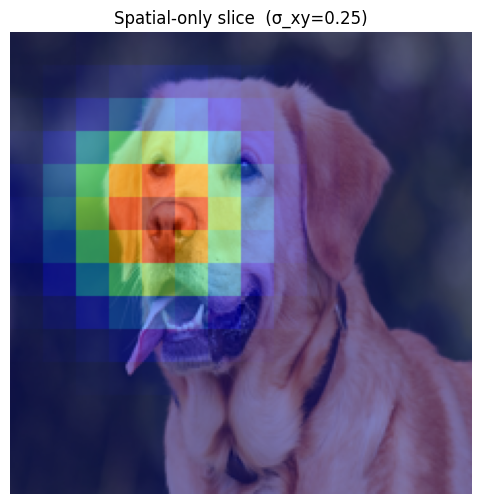

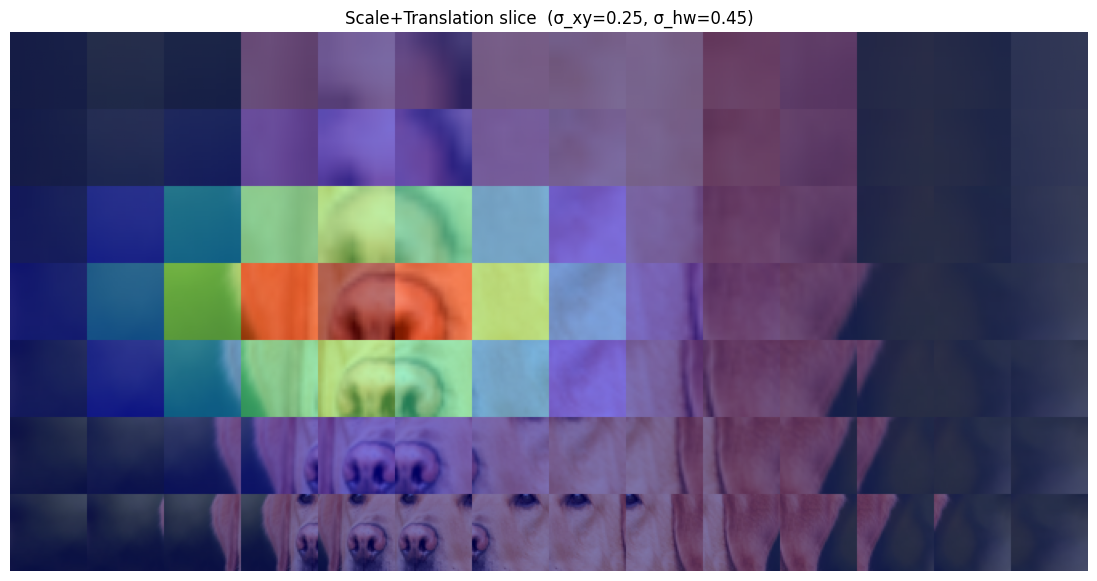

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def full_patch_kernel(dx, dy, dlogw, dlogh, sigma_xy, sigma_hw):
    """
    4-D Gaussian kernel over (dx, dy, dlogw, dlogh).
    """
    spatial_term = (dx**2 + dy**2) / (2 * sigma_xy**2)
    scale_w_term = (dlogw**2)    / (2 * sigma_hw**2)
    scale_h_term = (dlogh**2)    / (2 * sigma_hw**2)
    return np.exp(- (spatial_term + scale_w_term + scale_h_term))

def visualize_kernel_slices(
    img_path: str,
    sigma_xy: float,
    sigma_hw: float,
    patch_size: int = 16,
    k: int = 3,
    ref_patch: tuple[int,int] = None
):
    """
    Draw two overlays on the same 224×224 image (patch_size=16):
      A) Spatial-only: w(dx,dy,0,0)
      B) Scale+Translation: w(dx,0,log(s),log(s)) with s in [1/k..k]

    Params:
      img_path:   Path to image file
      sigma_xy:   σ for dx, dy
      sigma_hw:   σ for both dlogw, dlogh in production
      patch_size: patch side (pixels)
      k:          scale range factor
      ref_patch:  (row, col) index in 14×14 grid, defaults to center
    """
    # Load & resize
    img = Image.open(img_path).convert("RGB").resize((224,224))
    arr = np.array(img) / 255.0
    G = 224 // patch_size

    # Reference patch
    if ref_patch is None:
        pr = pc = G//2
    else:
        pr, pc = ref_patch

    # --- A) Spatial-only slice ---
    i, j   = np.meshgrid(np.arange(G), np.arange(G), indexing="ij")
    dx_sp  = (j - pc) / (G/2)
    dy_sp  = (i - pr) / (G/2)
    w_sp   = full_patch_kernel(
        dx_sp, dy_sp,
        dlogw=np.zeros_like(dx_sp),
        dlogh=np.zeros_like(dx_sp),
        sigma_xy=sigma_xy, sigma_hw=sigma_hw
    )
    heat_sp = np.kron(w_sp, np.ones((patch_size,patch_size)))

    plt.figure(figsize=(6,6))
    plt.imshow(arr, origin="upper")
    plt.imshow(heat_sp, origin="upper", cmap="jet", alpha=0.5)
    plt.title(f"Spatial-only slice  (σ_xy={sigma_xy})")
    plt.axis("off")
    plt.show()

    # --- B) Scale+Translation slice ---
    scales = np.logspace(np.log10(1/k), np.log10(k), 2*k+1)
    log_s  = np.log(scales)
    dy_st  = 0.0
    dlogw = log_s[:,None]
    dlogh = log_s[:,None]

    cols   = np.arange(G)
    dx_st  = (cols - pc)/(G/2)

    W_st = full_patch_kernel(
        dx=dx_st[None,:], dy=dy_st,
        dlogw=dlogw, dlogh=dlogh,
        sigma_xy=sigma_xy, sigma_hw=sigma_hw
    )  # shape (2k+1, G)

    # build canvas of resized crops
    max_sz = patch_size * k
    canvas = np.ones(((2*k+1)*max_sz, G*max_sz, 3), dtype=float)
    H, W = arr.shape[:2]
    y_center = pr*patch_size + patch_size//2

    for i, scale in enumerate(scales):
        size = max(1, int(patch_size*scale))
        half = size//2
        for j in range(G):
            x_center = j*patch_size + patch_size//2
            y0, y1 = y_center-half, y_center+half
            x0, x1 = x_center-half, x_center+half
            # clamp
            y0, y1 = max(0,y0), min(H,y1)
            x0, x1 = max(0,x0), min(W,x1)
            region = arr[y0:y1, x0:x1]
            patch_img = Image.fromarray((region*255).astype(np.uint8))
            fill = np.array(
                patch_img.resize((max_sz,max_sz), Image.BILINEAR)
            ) / 255.0
            canvas[i*max_sz:(i+1)*max_sz, j*max_sz:(j+1)*max_sz] = fill

    heat_st = np.kron(W_st, np.ones((max_sz,max_sz)))

    plt.figure(figsize=(G,2*k+1))
    plt.imshow(canvas, origin="upper")
    plt.imshow(heat_st, origin="upper", cmap="jet", alpha=0.5)
    plt.title(f"Scale+Translation slice  (σ_xy={sigma_xy}, σ_hw={sigma_hw})")
    plt.axis("off")
    plt.show()

# Example usage:
visualize_kernel_slices(
    "../../artifacts/labrador.jpg",
    sigma_xy=0.25,
    sigma_hw=0.45,
    patch_size=16,
    k=3,
    ref_patch=(5,4)
)


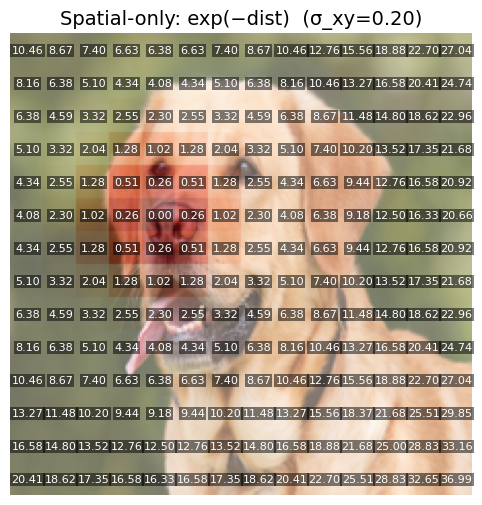

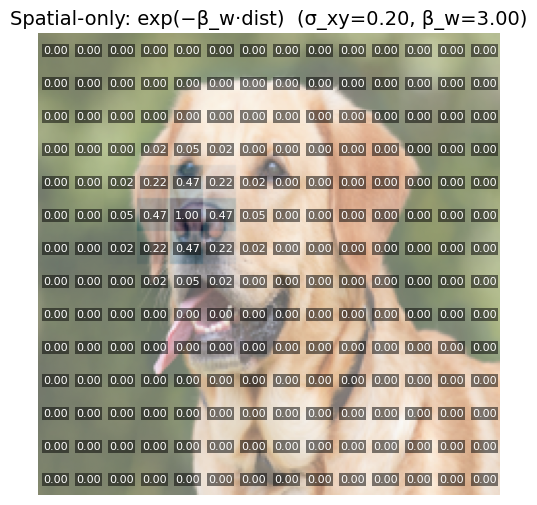

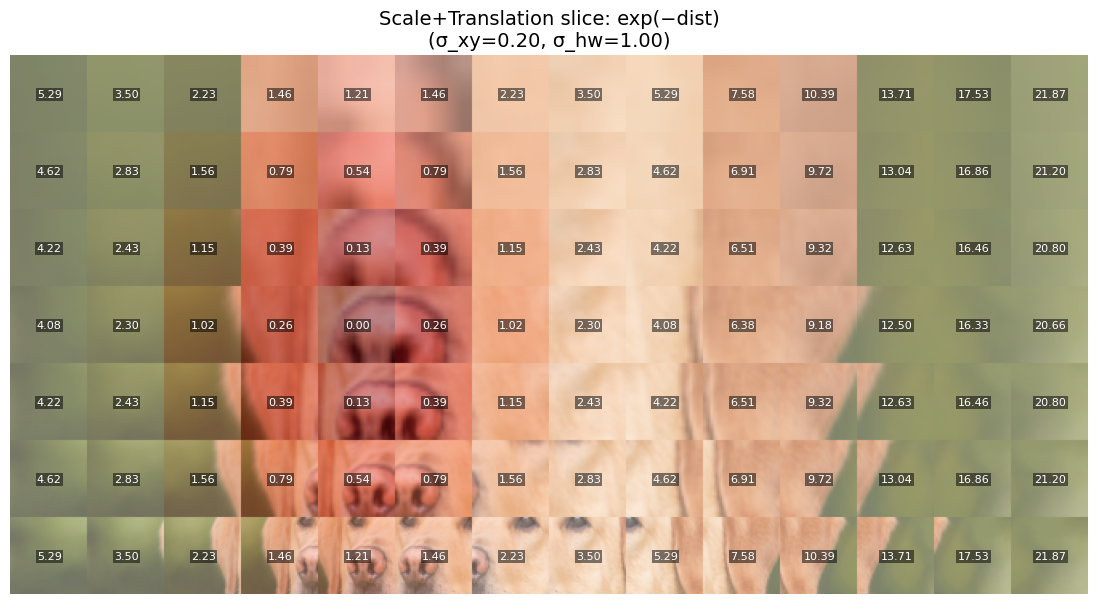

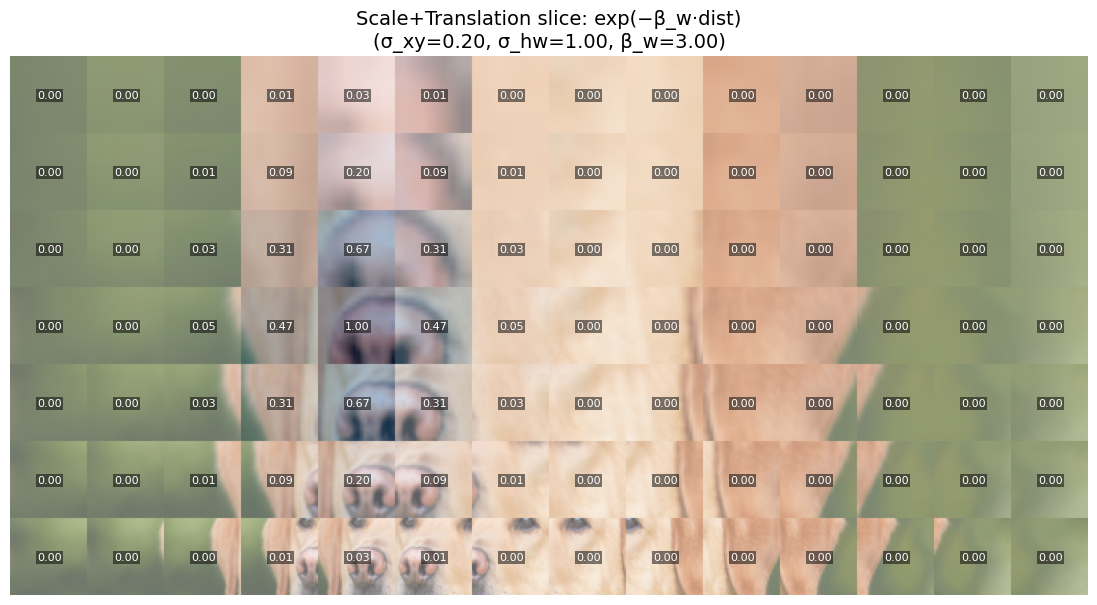

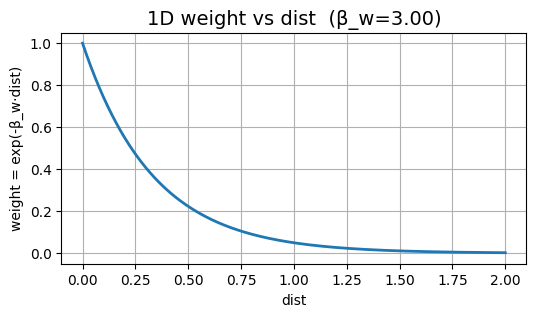

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def full_patch_dist(dx, dy, dlogw, dlogh, sigma_xy, sigma_hw):
    """
    Compute squared‐Mahalanobis‐style distance:
      dist = (dx^2 + dy^2)/(2 σ_xy^2)  +  (dlogw^2 + dlogh^2)/(2 σ_hw^2).
    (Returned is the raw geometric cost, *not* exponentiated.)
    """
    spatial_term   = (dx**2 + dy**2)   / (2.0 * sigma_xy**2)
    scale_w_term   = (dlogw**2)       / (2.0 * sigma_hw**2)
    scale_h_term   = (dlogh**2)       / (2.0 * sigma_hw**2)
    return spatial_term + scale_w_term + scale_h_term

def visualize_kernel_and_weights_with_labels(
    img_path: str,
    sigma_xy: float,
    sigma_hw: float,
    beta_w: float,
    patch_size: int = 16,
    k: int = 3,
    ref_patch: tuple[int,int] = None
):
    """
    Enhanced visualization:
      - On the SPATIAL‐ONLY slice, we overlay both the “exp(−dist)” heatmap and
        the numeric dist value at each (row,col) of the G×G grid, plus numeric
        weight = exp(−β_w·dist) at each cell in the second subplot.
      - On the SCALE+TRANSLATION slice, which is (2k+1) × G, we overlay the “exp(−dist)”
        & “exp(−β_w·dist)” heatmaps, *and* annotate each of the (2k+1)*(G) cells with
        the numeric dist or weight values (in white text with a semi‐opaque black background).

    Args:
      img_path:   path to your 224×224 image (we will resize to 224×224).
      sigma_xy:   σ for dx,dy.
      sigma_hw:   σ for dlogw,dlogh.
      beta_w:     β_w parameter in exp(−β_w·dist).
      patch_size: side length of each patch in pixels (commonly 16 for 14×14 grid).
      k:          number of scale steps on either side (so total rows = 2k+1).
      ref_patch:  (row, col) in the G×G grid to use as “anchor.” Defaults to center.
    """
    # ——— 1) Load & normalize the image to 224×224 ———
    img = Image.open(img_path).convert("RGB").resize((224,224))
    arr = np.array(img) / 255.0

    # Grid size: if patch_size=16 on 224×224, then G = 14
    G = 224 // patch_size

    # ——— 2) Pick reference patch (pr, pc) in that G×G grid ———
    if ref_patch is None:
        pr = pc = G // 2
    else:
        pr, pc = ref_patch

    # ——— A) SPATIAL‐ONLY slice ———
    i, j   = np.meshgrid(np.arange(G), np.arange(G), indexing="ij")
    # Normalize dx,dy so that a shift of G/2 cells = normalized Δ=1
    dx_sp  = (j - pc) / (G / 2.0)
    dy_sp  = (i - pr) / (G / 2.0)
    # Keep dlogw = dlogh = 0 for purely spatial slice
    dist_sp = full_patch_dist(
        dx_sp, dy_sp,
        dlogw=np.zeros_like(dx_sp),
        dlogh=np.zeros_like(dx_sp),
        sigma_xy=sigma_xy, sigma_hw=sigma_hw
    )  # shape = [G, G]

    # Compute both “Gaussian cost” and “β_w‐weight”
    gauss_sp  = np.exp(-dist_sp)              # exp(−dist)
    weight_sp = np.exp(-beta_w * dist_sp)     # exp(−β_w·dist)

    # Upsample for pixel‐level heatmap
    heat_gauss_sp  = np.kron(gauss_sp,  np.ones((patch_size, patch_size)))
    heat_weight_sp = np.kron(weight_sp,np.ones((patch_size, patch_size)))

    # ——— Plot A.1: Base image + exp(−dist) overlay + “dist” labels ———
    plt.figure(figsize=(6,6))
    plt.title(f"Spatial‐only: exp(−dist)  (σ_xy={sigma_xy:.2f})", fontsize=14)
    plt.imshow(arr, origin="upper")
    plt.imshow(heat_gauss_sp, origin="upper", cmap="Reds", alpha=0.4)

    # Overlay the raw dist_sp values at the center pixel of each patch cell
    for row in range(G):
        for col in range(G):
            pixel_x = col * patch_size + patch_size // 2
            pixel_y = row * patch_size + patch_size // 2
            val = dist_sp[row, col]
            plt.text(
                pixel_x, pixel_y,
                f"{val:.2f}",
                color="white",
                fontsize=8,
                ha="center", va="center",
                bbox=dict(facecolor="black", alpha=0.5, pad=1, lw=0)
            )

    plt.axis("off")
    plt.show()

    # ——— Plot A.2: Base image + exp(−β_w·dist) overlay + “weight” labels ———
    plt.figure(figsize=(6,6))
    plt.title(f"Spatial‐only: exp(−β_w·dist)  (σ_xy={sigma_xy:.2f}, β_w={beta_w:.2f})", fontsize=14)
    plt.imshow(arr, origin="upper")
    plt.imshow(heat_weight_sp, origin="upper", cmap="Blues", alpha=0.4)

    # Overlay the weight_sp values at each patch cell center
    for row in range(G):
        for col in range(G):
            pixel_x = col * patch_size + patch_size // 2
            pixel_y = row * patch_size + patch_size // 2
            wval = weight_sp[row, col]
            plt.text(
                pixel_x, pixel_y,
                f"{wval:.2f}",
                color="white",
                fontsize=8,
                ha="center", va="center",
                bbox=dict(facecolor="black", alpha=0.5, pad=1, lw=0)
            )

    plt.axis("off")
    plt.show()

    # ——— B) SCALE+TRANSLATION slice ———
    # We build a canvas of (2k+1) rows and G columns, where each row corresponds
    # to a particular log‐scale, and each column to a horizontal shift. We then
    # overlay heatmaps and annotate each cell’s center with its numeric value.

    # 1) Define the 2k+1 discrete scales from 1/k to k in log‐space
    scales = np.logspace(np.log10(1.0/k), np.log10(k), 2*k + 1)
    log_s  = np.log(scales)          # shape = (2k+1,)
    dy_st  = 0.0                     # keep dy=0 for this slice
    # Prepare (2k+1)×1 arrays for dlogw and dlogh
    dlogw  = log_s[:, None]          # shape = (2k+1, 1)
    dlogh  = log_s[:, None]          # shape = (2k+1, 1)
    # Prepare 1×G array for dx
    dx_st  = (np.arange(G) - pc) / (G / 2.0)  # shape = (G,)

    # 2) Compute the raw dist for every (scale, dx) pair
    #    dist_st.shape = (2k+1, G)
    dist_st = full_patch_dist(
        dx   = dx_st[None, :], 
        dy   = dy_st,
        dlogw= dlogw, 
        dlogh= dlogh,
        sigma_xy=sigma_xy, 
        sigma_hw=sigma_hw
    )

    # 3) Compute both “Gaussian cost” and “β_w‐weight” for this slice
    gauss_st  = np.exp(-dist_st)                # shape = (2k+1, G)
    weight_st = np.exp(-beta_w * dist_st)       # shape = (2k+1, G)

    # 4) Build a “canvas” that shows each patch at each scale as a big upsampled tile
    max_sz = patch_size * k
    Hc = (2*k + 1) * max_sz
    Wc = G * max_sz
    canvas = np.ones((Hc, Wc, 3), dtype=float)

    H, W = arr.shape[:2]  # 224,224
    y_center = pr*patch_size + patch_size // 2

    for i_row, scale in enumerate(scales):
        size = max(1, int(patch_size * scale))
        half = size // 2
        for j_col in range(G):
            x_center = j_col * patch_size + patch_size // 2
            y0, y1 = y_center - half, y_center + half
            x0, x1 = x_center - half, x_center + half
            y0, y1 = max(0, y0), min(H, y1)
            x0, x1 = max(0, x0), min(W, x1)
            region = arr[y0:y1, x0:x1]
            patch_img = Image.fromarray((region * 255).astype(np.uint8))
            fill = np.array(
                patch_img.resize((max_sz, max_sz), Image.BILINEAR)
            ) / 255.0
            canvas[i_row*max_sz:(i_row+1)*max_sz,
                   j_col*max_sz:(j_col+1)*max_sz] = fill

    # 5) Upsample the 2D heatmaps so they align with “canvas” coordinates
    heat_gauss_st  = np.kron(gauss_st,  np.ones((max_sz, max_sz)))
    heat_weight_st = np.kron(weight_st,np.ones((max_sz, max_sz)))

    # ——— Plot B.1: Scaled‐patches canvas + exp(−dist) overlay + “dist” labels ———
    plt.figure(figsize=(G, 2*k + 1))
    plt.title(f"Scale+Translation slice: exp(−dist)\n(σ_xy={sigma_xy:.2f}, σ_hw={sigma_hw:.2f})", fontsize=14)
    plt.imshow(canvas, origin="upper")
    plt.imshow(heat_gauss_st, origin="upper", cmap="Reds", alpha=0.4)

    # Overlay dist_st values at the center of each (scale,row, dx,column) cell
    for row in range(2*k + 1):
        for col in range(G):
            # Center pixel of that cell in the large canvas:
            pixel_x = col * max_sz + max_sz // 2
            pixel_y = row * max_sz + max_sz // 2
            dval = dist_st[row, col]
            plt.text(
                pixel_x, pixel_y,
                f"{dval:.2f}",
                color="white",
                fontsize=8,
                ha="center", va="center",
                bbox=dict(facecolor="black", alpha=0.5, pad=1, lw=0)
            )

    plt.axis("off")
    plt.show()

    # ——— Plot B.2: Scaled‐patches canvas + exp(−β_w·dist) overlay + “weight” labels ———
    plt.figure(figsize=(G, 2*k + 1))
    plt.title(f"Scale+Translation slice: exp(−β_w·dist)\n(σ_xy={sigma_xy:.2f}, σ_hw={sigma_hw:.2f}, β_w={beta_w:.2f})", fontsize=14)
    plt.imshow(canvas, origin="upper")
    plt.imshow(heat_weight_st, origin="upper", cmap="Blues", alpha=0.4)

    # Overlay weight_st values at each cell center
    for row in range(2*k + 1):
        for col in range(G):
            pixel_x = col * max_sz + max_sz // 2
            pixel_y = row * max_sz + max_sz // 2
            wval = weight_st[row, col]
            plt.text(
                pixel_x, pixel_y,
                f"{wval:.2f}",
                color="white",
                fontsize=8,
                ha="center", va="center",
                bbox=dict(facecolor="black", alpha=0.5, pad=1, lw=0)
            )

    plt.axis("off")
    plt.show()

    # ——— Plot C: 1D weight vs dist curve for reference ———
    distances = np.linspace(0, 2.0, 201)
    weights_1d = np.exp(-beta_w * distances)
    plt.figure(figsize=(6,3))
    plt.plot(distances, weights_1d, linewidth=2)
    plt.ylim([-0.05,1.05])
    plt.xlabel("dist")
    plt.ylabel("weight = exp(-β_w·dist)")
    plt.title(f"1D weight vs dist  (β_w={beta_w:.2f})", fontsize=14)
    plt.grid(True)
    plt.show()


# ==== Example usage ====
visualize_kernel_and_weights_with_labels(
    img_path="../../artifacts/labrador.jpg",
    sigma_xy=0.2,    # e.g. ~1 patch shift = 1σ
    sigma_hw=1.0,    # e.g. ~20% scale change = 1σ
    beta_w=3.0,       # “dist>0.6 → weight<0.1”
    patch_size=16,
    k=3,
    ref_patch=(5,4)   # center of a 14×14 grid is (7,7), but you can pick any
)


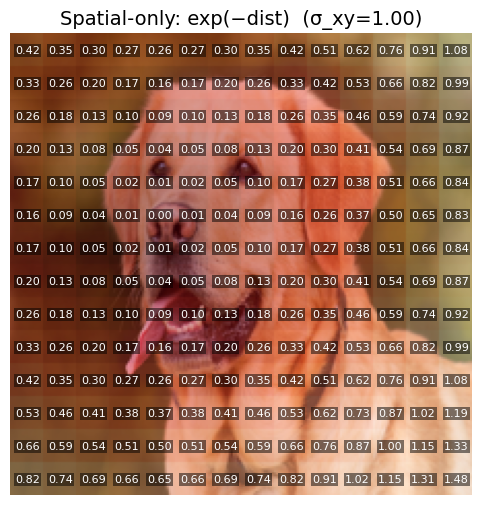

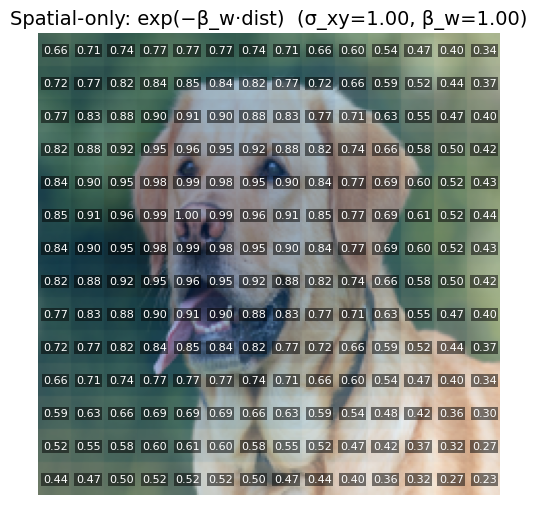

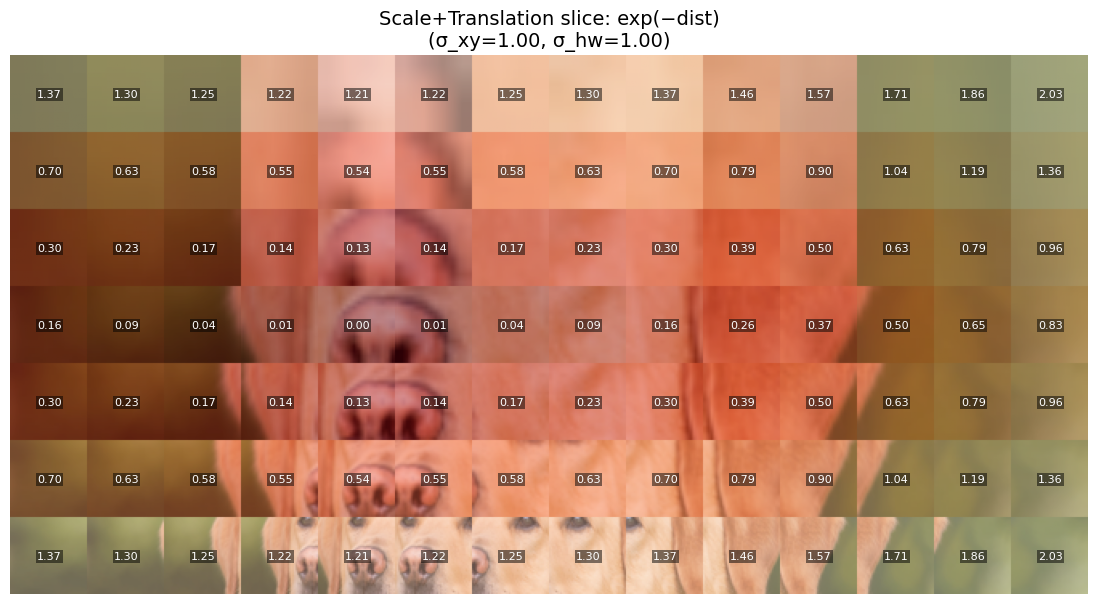

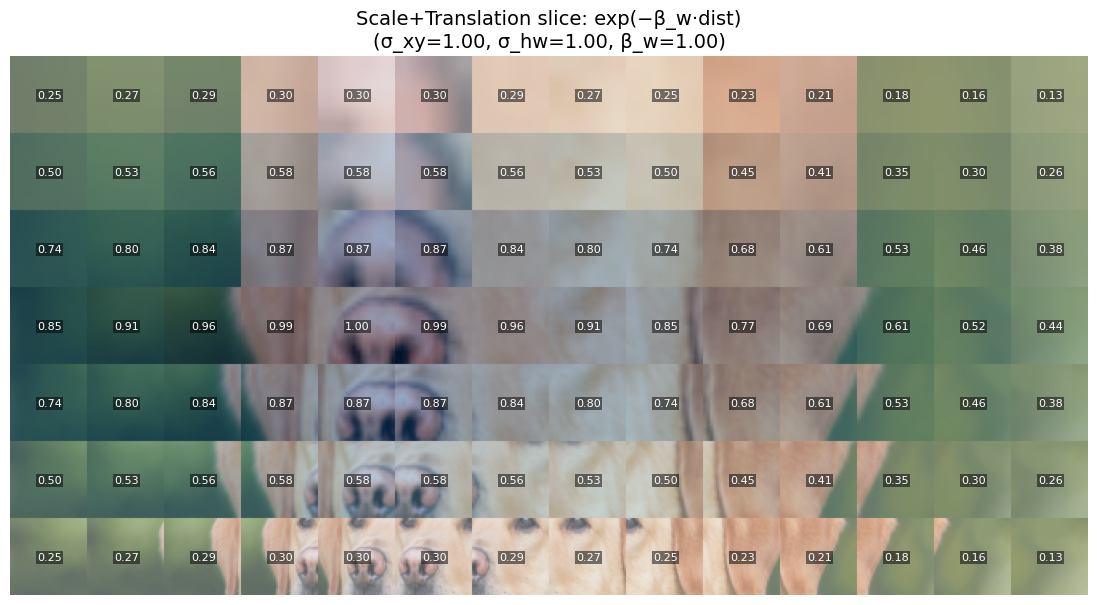

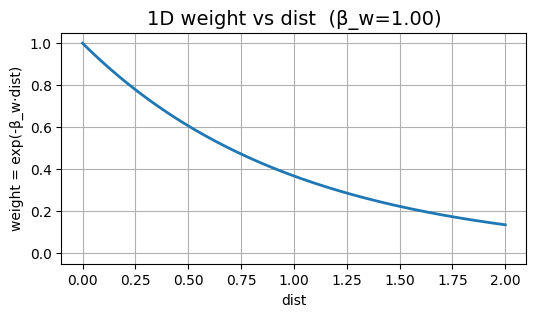

In [33]:
visualize_kernel_and_weights_with_labels(
    img_path="../../artifacts/labrador.jpg",
    sigma_xy=1.0,    # e.g. ~1 patch shift = 1σ
    sigma_hw=1.0,    # e.g. ~20% scale change = 1σ
    beta_w=1.0,       # “dist>0.6 → weight<0.1”
    patch_size=16,
    k=3,
    ref_patch=(5,4)   # center of a 14×14 grid is (7,7), but you can pick any
)
